## Przygotowanie

Przed rozpoczęciem pracy z notatnikiem proszę zmienić jego nazwę dodając na początku numer albumu, imię i nazwisko.
{nr_albumu}\_{imię}\_{nazwisko}\_{nazwa}

Po wykonaniu wszystkich zadań proszę przesłać wypełniony notatnik przez platformę ELF za pomocą formularza "Prześlij projekt" w odpowiedniej sekcji. 

## Regresja wielomianowa

Regresja liniowa działa dobrze w sytuacji, gdy zmienna, której wartość chemy przewidzieć (zmienna objaśniana/zależna) jest liniowo zależna od zmiennych za pomocą których chcemy ją obliczyć (zmiennych objaśniających/niezależnych). Jak nietrudno się domyślić, takie założenie jest mocno ograniczające i w realnych problemach rzadko będzie ono spełniane. Pojawia się zatem pytanie, co zrobić, gdy wiemy, że dane nie spełniają założenia o liniowej zależności. Istnieje wiele algorytmów rozwiązujących takie problemy. Jednym z nich jest regresja wielomianowa.

Regresja wielomianowa polega na zmianie funkcji regresji tak, aby była to funkcja wielomianowa. Przykładowo, dla jednej zmiennej niezależnej można stworzyć model, którego funkcja regresji będzie wielomianem czwartego stopnia: 

\begin{equation}
f(x) = \beta_{0} + \beta_{1}x_1 + \beta_{2}x_1^2 + \beta_{3}x_1^3 + \beta_{4}x_1^4
\end{equation}

Pozwala to na stworzenie dowolnego kształtu funkcji, który będzie dopasowany do danych. Zwiekszanie krotności wielomianu spowoduje dokładniejsze dopasowanie do danych, jednak rodzi też pewne niebezpieczeństwa. Może okazać się, że taki model będzie zbyt mocno dopasowany do próbek uczących i nie będzie w stanie dokonywać poprawnych predykcji dla nowych, nieznanych próbek. Takie zjawisko nazywa się przeuczeniem modelu i istnieją różne metody do jego rozpoznania i przeciwdziałania. Nie jest to jednak przedmiotem tego notatnika. 

Cały proces trenowania i testowania modelu wygląda jak w przypadku regresji liniowej. Różnica polega jedynie na zmianie funkcji regresji.

Zbiór danych do tego zadania znajduje się w pliku "jaws.csv" i przedstawia zależność długości kości szczękowej jelenia od jego wieku. 

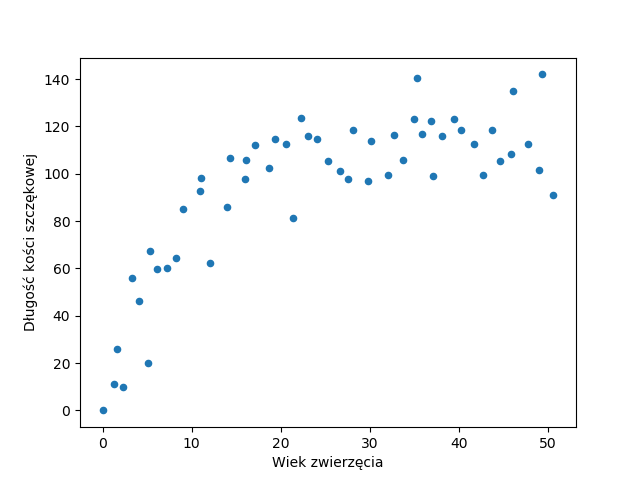

Na powyższym wykresie widać, że zależność na pewno nie jest liniowa. Szczęka zwierzęcia rośnie do pewnego wieku i później jej długość jest stała przez resztę życia. Spróbujemy rozwiązać ten problem za pomocą regresji wielomianowej.

### Zadanie 1
Aby stworzyć funkcję wielomianową konieczne jest dodanie nowych cech do istniejącego zestawu danych.  
Stwórz funkcję, która przetransformuje pojedynczą cechę do wektora cech, w którym kolejne elementy, to kolejne potęgi danej cechy. 

Przykład:  
transform_to_polynomial_feature(x, 5) -> $[x^1, x^2, x^3, x^4, x^5]$  
transform_to_polynomial_feature(x, 3) -> $[x^1, x^2, x^3]$

In [227]:
'''
input:
x - wartość zmiennej niezależnej
n - stopień wielomianu

output:
out: [] - lista o długości n z kolejnymi potęgami wejściowej cechy x
'''
def transform_to_polynomial_feature(x, n):
    out = [pow(x, i) for i in range(1, n + 1)]
    return out

In [228]:
transform_to_polynomial_feature(4, 5)

[4, 16, 64, 256, 1024]

### Zadanie 2

Zmodyfikuj swój kod z zadania z regresją liniową tak, aby dla zestawu danych x z jedną zmienną niezależną tworzył nieliniową funkcję regresji. Przetestuj rozwiązanie dla różnych wariantów stopnia wielomianu.
Pamiętaj, że konieczne dodanie dodatkowych cech do oryginalnego zbioru danych, które będą kolejnymi potęgami zmiennej niezależnej - wiek zwierzęcia. 

In [229]:
import random

def calculate_prediction(X, row, betas):
    prediction = betas[0]
    for col in range(1, len(betas)):
        prediction += betas[col] * X.iloc[row][col - 1]
    return prediction


def get_predictions(X, betas):
    return [calculate_prediction(X, row, betas) for row in range(len(X))]


def calculate_ssr(y, y_pred):
    ssr = 0
    for row in range(len(y)):
        ssr += ((y_pred[row] - y[row]) ** 2)
    ssr /= (2 * len(y))
    return ssr


def calculate_derivatives(X, y, y_pred):
    der = [0 for i in range(X.shape[1] + 1)]  
    
    for col in range(len(der)):
        for row in range(len(X)):
            if(col == 0):
                der[col] += (y_pred[row] - y[row])
            else:
                der[col] += (y_pred[row] - y[row]) * X.iloc[row][col - 1]       
        der[col] /= len(X)

    return der


def update_betas(betas, alpha, ssr, der):
    for col in range(len(der)):
        betas[col] -= (alpha * der[col])
        
    return betas

In [243]:
def standarize(X):
    mean = X.mean(axis = 0) 
    std = X.std(axis = 0) 
    i = 0

    for col in X.columns.tolist():
        if std[col] != 0: 
            X[col] -= mean[i]
            X[col] /= std[i]
        else:
            X[col] = 0
        i += 1
            
    return X

In [245]:
import pandas as pd

'''
input:
x - wartości zmiennej objaśniającej dla wszystkich obserwacji
y - wartości zmiennej objaśnianej dla wszystkich obserwacji
n - stopień wielomianu
alpha - wspólczynnik alpha

output:
b0: [] - lista z współczynnikami beta_0 w każdej z epok
b1: [] - lista z współczynnikami beta_1 w każdej z epok
error: [] - lista z błędem w każdej epoce
y_pred: [] - lista z wartościami predykcji w ostatniej epoce
'''

def learn_and_fit_multi(x, y, n, alpha):
    b0 = []
    betas = []
    error = []
    
    epochs = 1000

    betas_tmp = [random.uniform(0, 1) for i in range(n + 1)]
    
    data = [transform_to_polynomial_feature(x[i], n) for i in range(len(x))] 
    X = pd.DataFrame(data)
    scaled_X = standarize(X)
    
    for epoch in range(epochs):
        y_pred = get_predictions(scaled_X, betas_tmp)
        ssr = calculate_ssr(y, y_pred)
        der = calculate_derivatives(X, y, y_pred)
        betas_tmp = update_betas(betas_tmp, alpha, ssr, der)
        
        b0.append(betas_tmp[0])
        betas.append(betas_tmp[1:])
        error.append(ssr)
            
    return b0, betas, error, y_pred

In [246]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_error(error):
    fig = plt.figure(figsize=(10, 5))

    plt.xlabel('epoch')
    plt.ylabel('SSR')

    plt.plot([i for i in range(len(error))], error, 'r-') 
    plt.show()

### Zadanie 3

Stwórz wykres na którym będą znajdować się dane ze zbioru _jaws.csv_ oraz funkcje regresji wielomianowej dla wielomianu pierwszego, czwartego i piątego stopnia. 

Opisz wykres. Jak zmienia się funkcja regresji wraz z dodawaniem kolejnych stopni wielomianu? Czy widzisz jakąś inną możliwą transformację funkcji regresji tak, żeby rozwiązała analizowany problem?

In [247]:
df = pd.read_csv('datasets/jaws.csv', sep=',')
x = df['age'].values
y = df['bone'].values

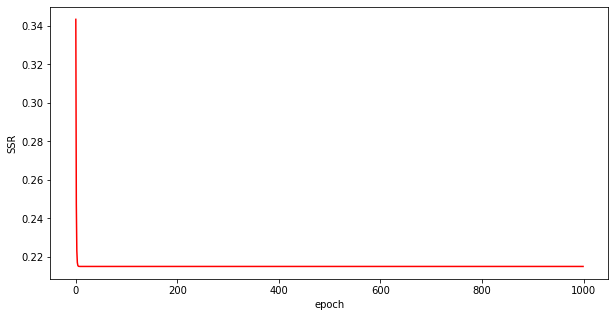

In [255]:
b0_1, betas_1, error_1, pred_1 = learn_and_fit_multi(x, y, 1, 0.5)
plot_error(error_1)

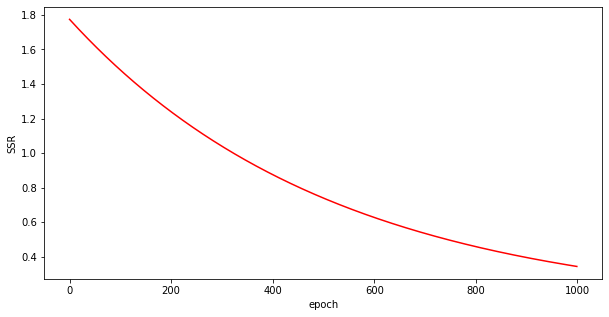

In [256]:
b0_4, betas_4, error_4, pred_4 = learn_and_fit_multi(x, y, 4, 0.0005)
plot_error(error_4)

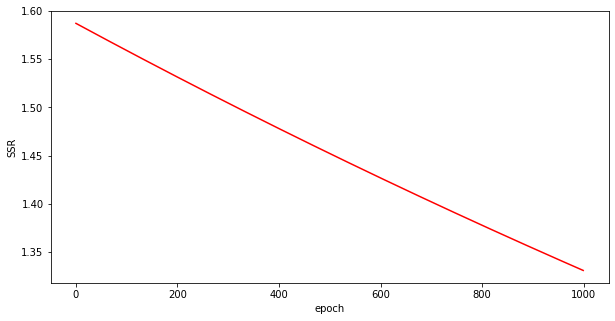

In [257]:
b0_5, betas_5, error_5, pred_5 = learn_and_fit_multi(x, y, 5, 0.00005)
plot_error(error_5)

Analizując powyższe wykresy nasuwa się wniosek, wskazujący na szybszy spadek błędu im niższy jest stopień  wielomianu. Im wyższy stopień wielomianu, tym zależność błędu względem kolejnych epok jest coraz bardziej liniowa. Zbieżność błędu do zera jest szybsza, im niższy stopień wielomianu. Warto zaznaczyć, że istotnym czynnikiem wpływającym na wysokość błędu jest współczynnik aplha, który został indywidualnie dobrany do każdego przypadku - stopnia wielomianu.

Natomiast poniższy wykres prezentuje funkcje regresji wielomianowej dla wielomianu od pierwszego, czwartego i piątego stopnia. Jak widać, pomimo sukcesywnego zminimalizowania błędu SSR dla wszystkich trzech przypadków otrzymane predykcje nie zawsze są  dobrym odwzorowaniem faktycznych etykiet. Funkcja regresji wielomianowej dla wielomianu od pierwszego jest liniowa i nadal niesie za sobą dużą rozbieżność między faktyczną a predykowaną etykietą. Warto zauważyć, że funkcje regresji dla wielomianu wyższego stopnia radzą sobie znacznie lepiej z predykcją, różnicę widać nawet między funkcją regresji dla wielomianu czwartego i piątego stopnia.

In [258]:
scaled_df = standarize(df)
scaled_x = scaled_df['age'].values
scaled_y = scaled_df['bone'].values

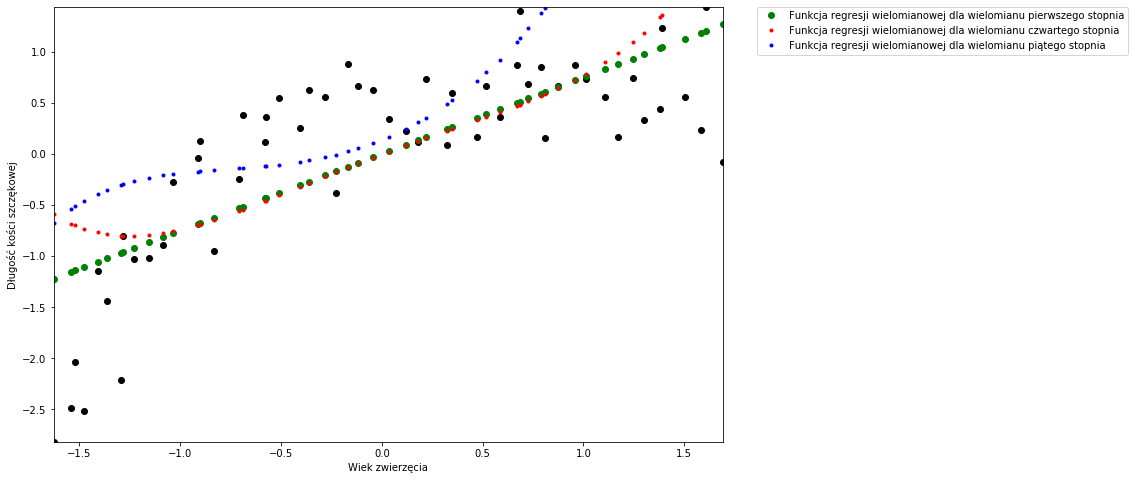

In [260]:
plt.figure(figsize=(12, 8))

plt.xlabel('Wiek zwierzęcia')
plt.ylabel('Długość kości szczękowej')

plt.ylim(min(scaled_y), max(scaled_y)) 
plt.xlim(min(scaled_x), max(scaled_x)) 

plt.plot(scaled_x, scaled_y, 'ko')
plt.plot(scaled_x, pred_1, 'go', label = 'Funkcja regresji wielomianowej dla wielomianu pierwszego stopnia')
plt.plot(scaled_x, pred_4, 'r.', label = 'Funkcja regresji wielomianowej dla wielomianu czwartego stopnia')
plt.plot(scaled_x, pred_5, 'b.', label = 'Funkcja regresji wielomianowej dla wielomianu piątego stopnia') 

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()